In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.patches import RegularPolygon
import matplotlib.patches as mpatches
from matplotlib import cm
import numpy as np
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval
from adjustText import adjust_text

# First time we use seaborn
import seaborn as sns

from mplsoccer import Pitch, VerticalPitch, lines

from PIL import Image
import urllib
import os

from math import acos, pi
from scipy.stats import circmean
import pickle

In [10]:
font_path = "/usr/share/fonts"
for x in os.listdir(font_path):
    #for y in os.listdir(f"{font_path}/{x}"):
    if x.split(".")[-1] == "ttf":
        #fm.fontManager.addfont(f"{font_path}/{x}/{y}")
        fm.fontManager.addfont(f"{font_path}/{x}")
        try:
            #fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            fm.FontProperties(weight=x.split("-")[-1].split(".")[0].lower(), fname=x.split("-")[0])
        except Exception:
            continue

plt.style.use("gray_style")
# root@b538d9565e4e:/work# ls ~/.config/matplotlib/stylelib/
# gray_style.mplstyle

In [48]:
data = pd.read_csv(f'/work/assets/whoscored/barcelona/match/2223/eventsData/2223#{gw}.csv', index_col=0, low_memory=False)
data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]
data['satisfied_events_types'] = [literal_eval(x) for x in data['satisfiedEventsTypes']]
df = data[data['outcomeType'] == 'Successful'].reset_index(drop=True)

df.loc[:, 'is_open_play'] = True
for index, record in enumerate(df['satisfied_events_types']):
    for attr in record:
        if attr in ['GoalKick', 'FreekickTaken', 'CornerTaken', 'throwIn', "passCorner"]:
            df.loc[index, 'is_open_play'] = False

print(len(df))
df = df[df['is_open_play']].reset_index(drop=True)
print(len(df))



1134
1102


In [49]:
def make_passSolar_data(gw, target_player_id, target_team_id):
    
    data = pd.read_csv(f'/work/assets/whoscored/barcelona/match/2223/eventsData/2223#{gw}.csv', index_col=0, low_memory=False)
    data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]
    data['satisfied_events_types'] = [literal_eval(x) for x in data['satisfiedEventsTypes']]
    df = data[data['outcomeType'] == 'Successful'].reset_index(drop=True)
    
    df.loc[:, 'is_open_play'] = True
    for index, record in enumerate(df['satisfied_events_types']):
        for attr in record:
            if attr in ['GoalKick', 'FreekickTaken', 'CornerTaken', 'throwIn', "passCorner"]:
                df.loc[index, 'is_open_play'] = False
    
    df = df[df['is_open_play']].reset_index(drop=True)
    
    df = df.assign(dx = lambda x: x.endX - x.x)
    df = df.assign(dy = lambda x: x.endY - x.y)
    df = df.assign(length_pass = lambda x: (x.dx**2 + x.dy**2)**(1/2))
    df.dropna(subset=["dx", "dy"], inplace=True)
    
    with open(file=f"/work/assets/whoscored/barcelona/ids/2223/2223#{gw}.json", mode="rb") as file:
        team_players_dict = pickle.load(file)

    id_name_dict = {}
    for venue in team_players_dict.keys():
        for _id, _name in team_players_dict[venue].keys():
            id_name_dict[_id] = _name
            
    df = df[df["teamId"] == target_team_id]
    df['playerName'] = [id_name_dict[i] for i in list(df['playerId'])]
    df['pass_recipient_id'] = df['playerId'].shift(-1)
    df['pass_recipient'] = df['playerName'].shift(-1)
    df = df[df["playerId"] == target_player_id].reset_index()

    target_player_name = df[df["playerId"]==target_player_id].loc[0, "playerName"]
    
    angle = np.arctan2(df.dy, df.dx)
    angle[angle < 0] = 2 * np.pi + angle[angle < 0]
    df["angle"] = angle + (np.pi/2)
    df[["playerName", "pass_recipient", "angle"]]
    
    df = df[df["pass_recipient_id"] != target_player_id]
    
    df_angle = df.groupby(['pass_recipient']).apply(lambda x: circmean(x.angle)).reset_index(name='angle')
    df_length = df.groupby(['pass_recipient'])['length_pass'].mean().reset_index()
    df_size = df.groupby(['pass_recipient'])['matchId'].size().reset_index(name='num_passes')

    df_summary = pd.merge(df_angle, df_length, on='pass_recipient')
    df_summary = pd.merge(df_summary, df_size, on='pass_recipient')
    df_summary['annotate'] = [True if x > 1 else False for x in df_summary['num_passes']]
    
    return (target_player_name, df_summary)


def plot_fancy_polar(ax):
    '''
    This function plots a fancy polar chart with ticks and
    other cool aesthetics.
    '''
    # -- Remove ticks and labels.
    ax.set_thetalim(0, 2 * np.pi)
    ax.set_rlim(0, 35)
    ax.set_xticks([])
    ax.set_xticklabels([])
    # -- Aux computation for bands
    ax.set_yticks(np.linspace(0, 40, 9))
    ax.set_yticklabels([])
    ax.tick_params("both", grid_alpha=0.50, grid_zorder=-10, grid_linewidth=0.5)
    ax.set_ylabel(None)

    # -- Draw angle ticks
    radius = ax.get_rmax()
    length = 0.05 * radius
    for i in range(360):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - length],
            linewidth=0.50,
            color="0.75",
            clip_on=False,
        )
    for i in range(0, 360, 5):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - 2 * length],
            linewidth=0.75,
            color="0.75",
            clip_on=False,
        )
    # Draw edges and add annotations
    for i in range(0, 360, 90):
        angle = np.pi * i / 180
        ax.plot([angle, angle], [radius, 0], zorder=3, linewidth=1.00, color="gray")
        if i == 0:
            text_ = 'Right'
        elif i == 90:
            text_ = 'Opposition goal'
        elif i == 180:
            text_ = 'Left'
        else:
            text_ = 'Own goal'
        ax.text(
            angle,
            radius + 4 * length,
            text_,
            zorder=3,
            rotation=i - 90,
            rotation_mode="anchor",
            va="top",
            ha="center",
            size="x-small",
            family="Nippo",
            color="black",
        )

    # --  Radius ticks
    length = .5*length
    def polar_to_cartesian(theta, radius):
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.array([x, y])


    def cartesian_to_polar(x, y):
        radius = np.sqrt(x ** 2 + y ** 2)
        theta = np.arctan2(y, x)
        return np.array([theta, radius])


    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, 0.75 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], linewidth=0.50, color="gray")

    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, +1.0 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], zorder=3, linewidth=0.75, color="gray")
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, -1.0 * length]))
        text = ax.text(
            P1[0],
            P1[1],
            f'{i*1.15:.0f}',
            zorder=3,
            va="top",
            ha="center",
            size="xx-small",
            family="Nippo",
            color="gray",
        )
        text.set_path_effects(
            [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
        )


    # -- Circular bands
    n = 35
    T = np.linspace(0, 2 * np.pi, n)
    color_even = "0.95"
    increase_size = 35/7
    cutoff = 0
    while cutoff <= 35:
        if cutoff % 2 == 0:
            color = color_even
            ax.fill_between(T, cutoff, cutoff + increase_size, color=color_even, zorder=-50)
        cutoff += increase_size
    ax.scatter([0], [0], 20, facecolor="white", edgecolor="gray", zorder=1000)

In [50]:
gw = 31
target_player_id = 382234
target_player_id2 = 300447
target_team_id = 65

target_player_name, df_summary = make_passSolar_data(gw=gw, target_player_id=target_player_id, target_team_id=target_team_id)
target_player_name2, df_summary2 = make_passSolar_data(gw=gw, target_player_id=target_player_id2, target_team_id=target_team_id)

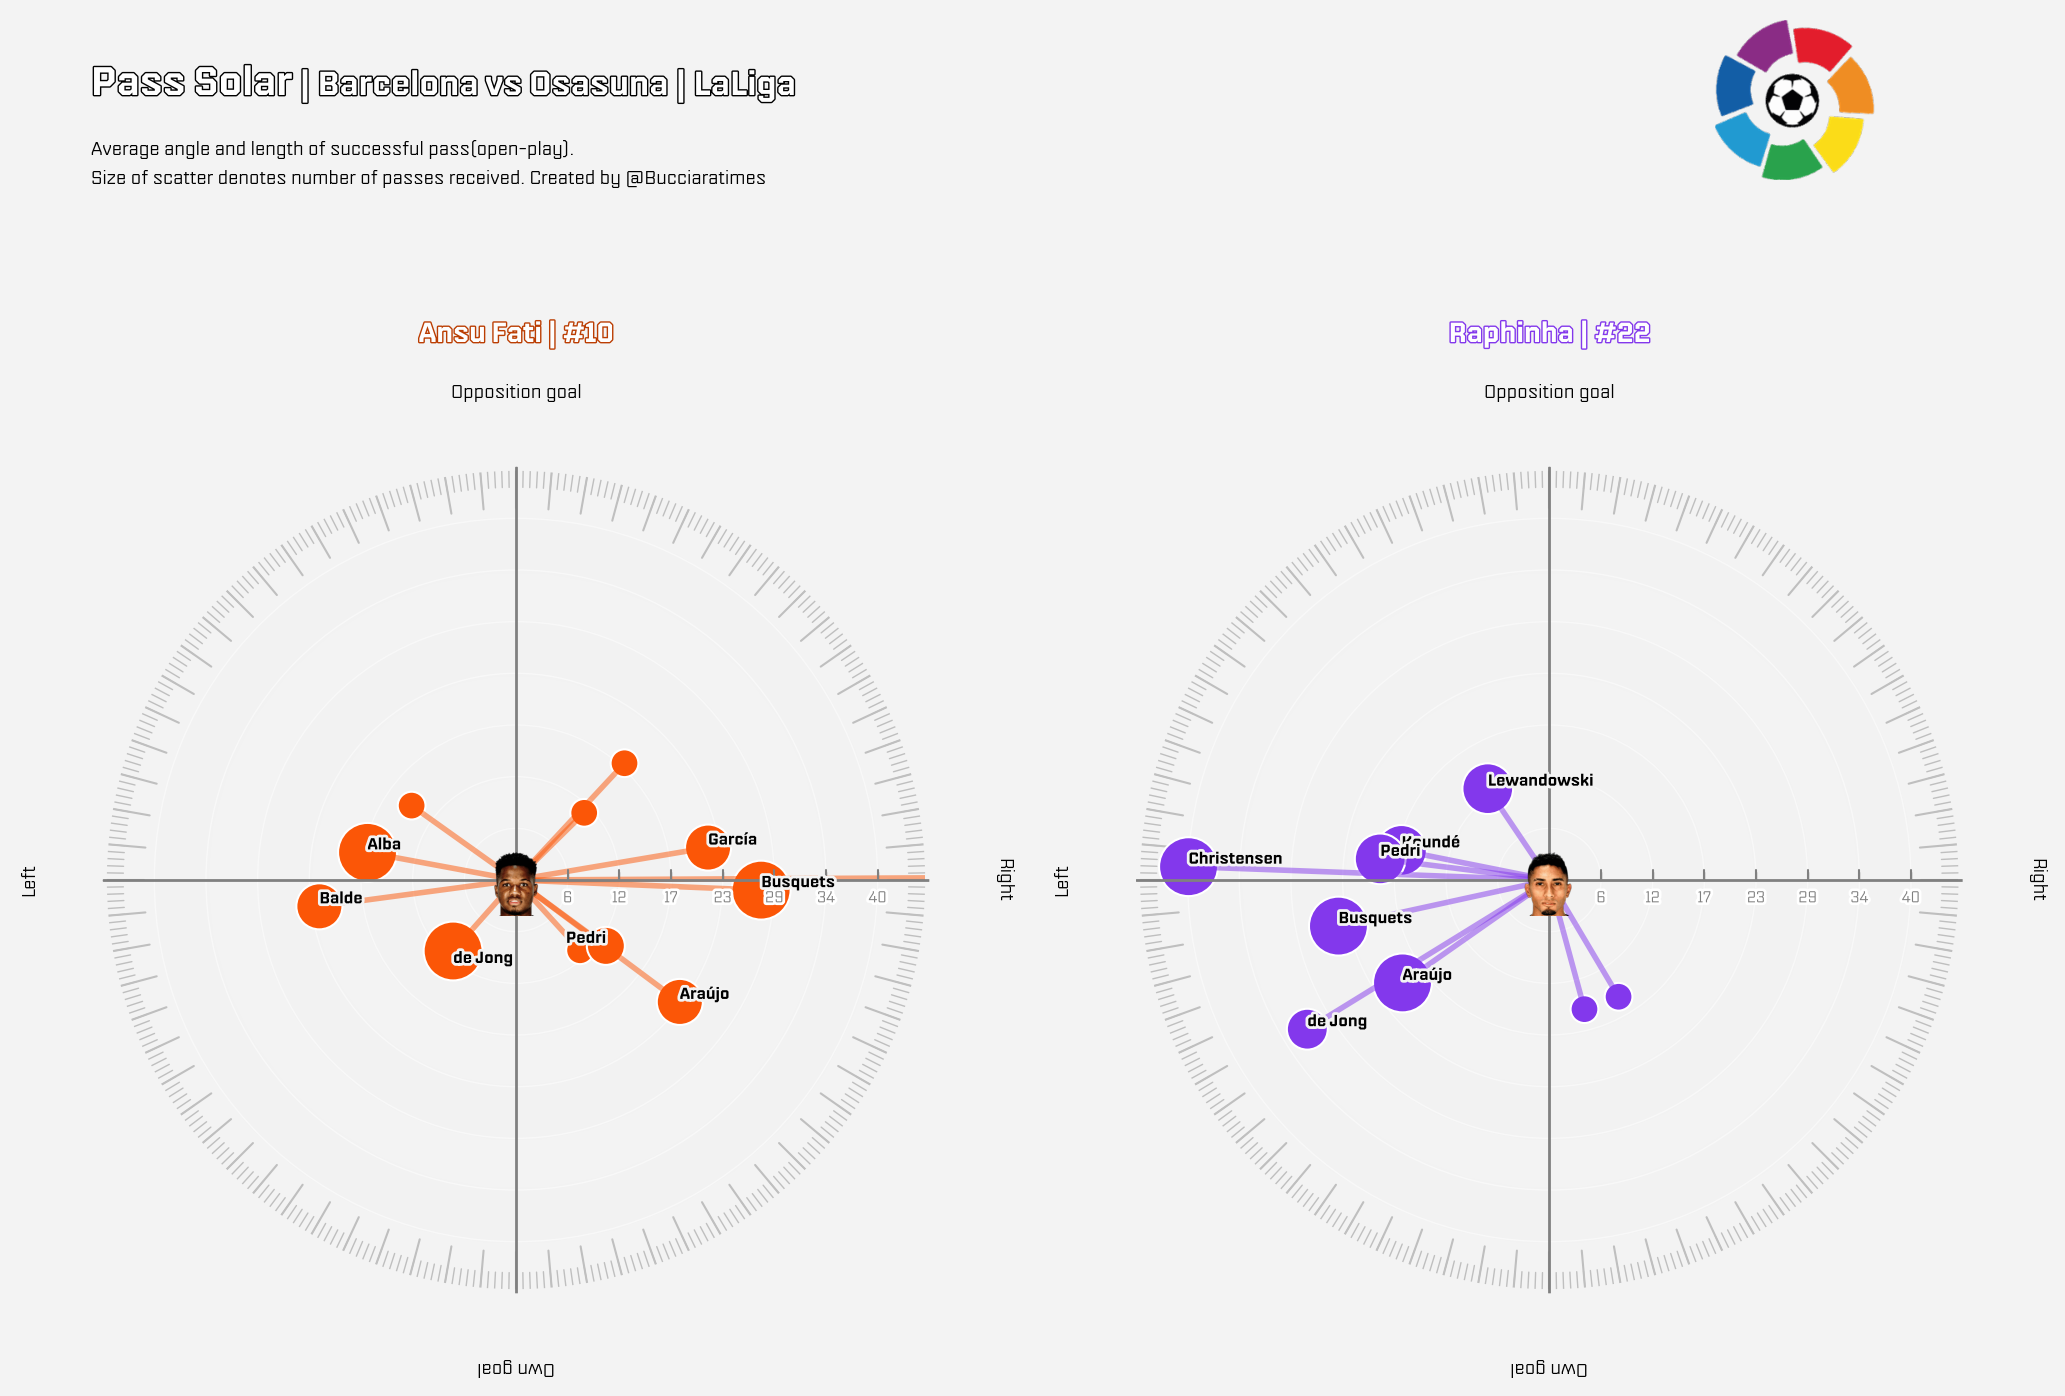

In [51]:
fig = plt.figure(dpi=200)
ax_one = plt.subplot(1, 2, 1, projection="polar", frameon=True)
ax_two = plt.subplot(1, 2, 2, projection="polar", frameon=True)

# -- one
one_color = "#fb5607"

plot_fancy_polar(ax_one)
sns.scatterplot(
    data=df_summary, x='angle', y='length_pass', color=one_color,
    size='num_passes', sizes=(100,450), legend=False, ax=ax_one, zorder=2)
ax_one.set_ylabel(None)
texts = []
df_annotate = df_summary[df_summary['annotate']]
for index in range(df_annotate.shape[0]):
    player_name = df_annotate['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_one.text(
            x=df_annotate['angle'].iloc[index], y=df_annotate['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Nippo', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(df_summary['length_pass']):
    ax_one.plot(
        [0, df_summary['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color=one_color
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_one)

# -- two
two_color = "#8338ec"

plot_fancy_polar(ax_two)
sns.scatterplot(
    data=df_summary2, x='angle', y='length_pass', color=two_color,
    size='num_passes', sizes=(100,450), legend=False, ax=ax_two, zorder=2)
ax_two.set_ylabel(None)
texts = []
df_annotate = df_summary2[df_summary2['annotate']]
for index in range(df_annotate.shape[0]):
    player_name = df_annotate['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_two.text(
            x=df_annotate['angle'].iloc[index], y=df_annotate['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Nippo', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(df_summary2['length_pass']):
    ax_two.plot(
        [0, df_summary2['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color=two_color
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_two)

plt.subplots_adjust(wspace=.25, hspace=-.5)

# =============================================================================== #

def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]

custom_path_effect_one = path_effect_stroke(linewidth=1, foreground='#bb3e03')
custom_path_effect_two = path_effect_stroke(linewidth=1, foreground='#8338ec')
custom_path_effect_title = path_effect_stroke(linewidth=1, foreground='#000000')



fig_text(
    x=0.12, y=1, s=f'<Pass Solar> | Barcelona vs Osasuna | LaLiga', family='Nippo',
    ha='left', va='center', weight='bold', size='large', color="#fefefe",
    highlight_textprops = [{'weight':'bold', 'size':'x-large'}],
    path_effects=custom_path_effect_title
)
fig_text(
    x=0.12, y=0.95, s='Average angle and length of successful pass(open-play).\nSize of scatter denotes number of passes received. Created by @Bucciaratimes', 
    family='Nippo',
    ha='left', va='center', size='x-small',
)

title_one = ax_one.set_title(
    label=f'{target_player_name} | #10',
    y=1.05,
    fontdict={
        'fontsize': "medium",
        'fontweight': "bold",
        'color': "#fefefe",
        'family': "Nippo"
    }
)
title_one.set(
    path_effects=custom_path_effect_one
)

title_two = ax_two.set_title(
    label=f'{target_player_name2} | #22',
    y=1.05,
    fontdict={
        'fontsize': "medium",
        'fontweight': "bold",
        'color': "#fefefe",
        'family': "Nippo"
    }
)
title_two.set(
    path_effects=custom_path_effect_two
)

image_ax = fig.add_axes(
    [.78, 0.94, .1, .1],
    fc='None'
)
fotmob_club_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/dark/87.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_club_url}')).convert('RGBA')
image_ax.imshow(club_icon)
image_ax.axis('off')

player_ax = fig.add_axes(
    [.277, .48, .04, .04],
    fc="None"
)
fotmob_player_url = f"https://images.fotmob.com/image_resources/playerimages/1086012.png"
player_icon = Image.open(urllib.request.urlopen(f'{fotmob_player_url}')).convert('RGBA')
player_ax.imshow(player_icon)
player_ax.axis('off')

player_ax2 = fig.add_axes(
    [.707, .48, .04, .04],
    fc="None"
)
fotmob_player_url2 = f"https://images.fotmob.com/image_resources/playerimages/696679.png"
player_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_player_url2}')).convert('RGBA')
player_ax2.imshow(player_icon2)
player_ax2.axis('off')

plt.savefig(
	"/work/output/02012023_pass_solar.png",
	dpi = 200,
	facecolor = "#191919",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

plt.savefig(
	"/work/output/020120234_pass_solar_tr.png",
	dpi = 200,
	# facecolor = "none",
    facecolor="#fefefe",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

In [24]:
gw = 31
data = pd.read_csv(f'/work/assets/whoscored/barcelona/match/2223/eventsData/2223#{gw}.csv', index_col=0, low_memory=False)
# data['x']=data['x']*1.2
# data['endX']=data['endX']*1.2
# data['y']=data['y']*0.8
# data['endY']=data['endY']*0.8

data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]
data['satisfied_events_types'] = [literal_eval(x) for x in data['satisfiedEventsTypes']]

In [25]:
df = data[data['outcomeType'] == 'Successful'].reset_index(drop=True)

In [26]:
df.loc[:, 'is_open_play'] = True
for index, record in enumerate(df['qualifiers']):
    for attr in record:
        key_search = list(attr.keys())[0]
        if key_search in ['GoalKick', 'FreekickTaken', 'CornerTaken', 'ThrowIn']:
            df.iloc[index, 'is_open_play'] = False

In [27]:
df = df[df['is_open_play']].reset_index(drop=True)

In [28]:
df = df.assign(dx = lambda x: x.endX - x.x)
df = df.assign(dy = lambda x: x.endY - x.y)
df = df.assign(length_pass = lambda x: (x.dx**2 + x.dy**2)**(1/2))

In [29]:
df.dropna(subset=["dx", "dy"], inplace=True)
df.shape

(783, 265)

In [30]:
with open(file=f"/work/assets/whoscored/barcelona/ids/2223/2223#{gw}.json", mode="rb") as file:
    team_players_dict = pickle.load(file)

id_name_dict = {}
for venue in team_players_dict.keys():
    for _id, _name in team_players_dict[venue].keys():
        id_name_dict[_id] = _name
        
target_player_id = 279423
target_team_id = 65
df = df[df["teamId"] == 65]
df['playerName'] = [id_name_dict[i] for i in list(df['playerId'])]
df['pass_recipient_id'] = df['playerId'].shift(-1)
df['pass_recipient'] = df['playerName'].shift(-1)
df = df[df["playerId"] == target_player_id].reset_index()

target_player_name = df[df["playerId"]==target_player_id].loc[0, "playerName"]

In [31]:
# df['angle'] = [
#     acos( dx / length_pass) for dx, length_pass in zip(df['dx'], df['length_pass'])
# ]
# df['angle'] = [
#     pi + angle if dy < 0 else angle for angle, dy in zip(df['angle'], df['dy'])
# ]

angle = np.arctan2(df.dy, df.dx)
angle[angle < 0] = 2 * np.pi + angle[angle < 0]
df["angle"] = angle + (np.pi/2)
df[["playerName", "pass_recipient", "angle"]]

,playerName,pass_recipient,angle
0,Frenkie de Jong,Sergio Busquets,6.233721
1,Frenkie de Jong,Alejandro Balde,6.252222
2,Frenkie de Jong,Robert Lewandowski,7.548623
3,Frenkie de Jong,Sergio Busquets,6.121069
4,Frenkie de Jong,Pedri,7.673363
...,...,...,...
92,Frenkie de Jong,Ronald Araújo,6.090485
93,Frenkie de Jong,Eric García,3.605240
94,Frenkie de Jong,Pedri,6.305125
95,Frenkie de Jong,Ousmane Dembélé,7.379954


In [32]:
df = df[df["pass_recipient_id"] != target_player_id]

In [33]:
# df.dropna(subset=["playerId"], inplace=True)

df_angle = df.groupby(['pass_recipient']).apply(lambda x: circmean(x.angle)).reset_index(name='angle')
df_length = df.groupby(['pass_recipient'])['length_pass'].mean().reset_index()
df_size = df.groupby(['pass_recipient'])['matchId'].size().reset_index(name='num_passes')

df_summary = pd.merge(df_angle, df_length, on='pass_recipient')
df_summary = pd.merge(df_summary, df_size, on='pass_recipient')

In [34]:
def plot_fancy_polar(ax):
    '''
    This function plots a fancy polar chart with ticks and
    other cool aesthetics.
    '''
    # -- Remove ticks and labels.
    ax.set_thetalim(0, 2 * np.pi)
    ax.set_rlim(0, 35)
    ax.set_xticks([])
    ax.set_xticklabels([])
    # -- Aux computation for bands
    ax.set_yticks(np.linspace(0, 40, 9))
    ax.set_yticklabels([])
    ax.tick_params("both", grid_alpha=0.50, grid_zorder=-10, grid_linewidth=0.5)
    ax.set_ylabel(None)

    # -- Draw angle ticks
    radius = ax.get_rmax()
    length = 0.05 * radius
    for i in range(360):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - length],
            linewidth=0.50,
            color="0.75",
            clip_on=False,
        )
    for i in range(0, 360, 5):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - 2 * length],
            linewidth=0.75,
            color="0.75",
            clip_on=False,
        )
    # Draw edges and add annotations
    for i in range(0, 360, 90):
        angle = np.pi * i / 180
        ax.plot([angle, angle], [radius, 0], zorder=3, linewidth=1.00, color="gray")
        if i == 0:
            text_ = 'Right'
        elif i == 90:
            text_ = 'Opposition goal'
        elif i == 180:
            text_ = 'Left'
        else:
            text_ = 'Own goal'
        ax.text(
            angle,
            radius + 4 * length,
            text_,
            zorder=3,
            rotation=i - 90,
            rotation_mode="anchor",
            va="top",
            ha="center",
            size="x-small",
            family="Nippo",
            color="black",
        )

    # --  Radius ticks
    length = .5*length
    def polar_to_cartesian(theta, radius):
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.array([x, y])


    def cartesian_to_polar(x, y):
        radius = np.sqrt(x ** 2 + y ** 2)
        theta = np.arctan2(y, x)
        return np.array([theta, radius])


    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, 0.75 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], linewidth=0.50, color="gray")

    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, +1.0 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], zorder=3, linewidth=0.75, color="gray")
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, -1.0 * length]))
        text = ax.text(
            P1[0],
            P1[1],
            f'{i*1.15:.0f}',
            zorder=3,
            va="top",
            ha="center",
            size="xx-small",
            family="Nippo",
            color="gray",
        )
        text.set_path_effects(
            [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
        )


    # -- Circular bands
    n = 35
    T = np.linspace(0, 2 * np.pi, n)
    color_even = "0.95"
    increase_size = 35/7
    cutoff = 0
    while cutoff <= 35:
        if cutoff % 2 == 0:
            color = color_even
            ax.fill_between(T, cutoff, cutoff + increase_size, color=color_even, zorder=-50)
        cutoff += increase_size
    ax.scatter([0], [0], 20, facecolor="white", edgecolor="gray", zorder=1000)

In [35]:
# df_summary['annotate'] = [True if x > df_summary['num_passes'].quantile(0.25) else False for x in df_summary['num_passes']] 
df_summary['annotate'] = [True if x > 0 else False for x in df_summary['num_passes']] 

In [36]:
gw = 31
target_player_id = 279423
target_player_id2 = 44721
target_team_id = 65

target_player_name, df_summary = make_passSolar_data(gw=gw, target_player_id=target_player_id, target_team_id=target_team_id)
target_player_name2, df_summary2 = make_passSolar_data(gw=gw, target_player_id=target_player_id2, target_team_id=target_team_id)


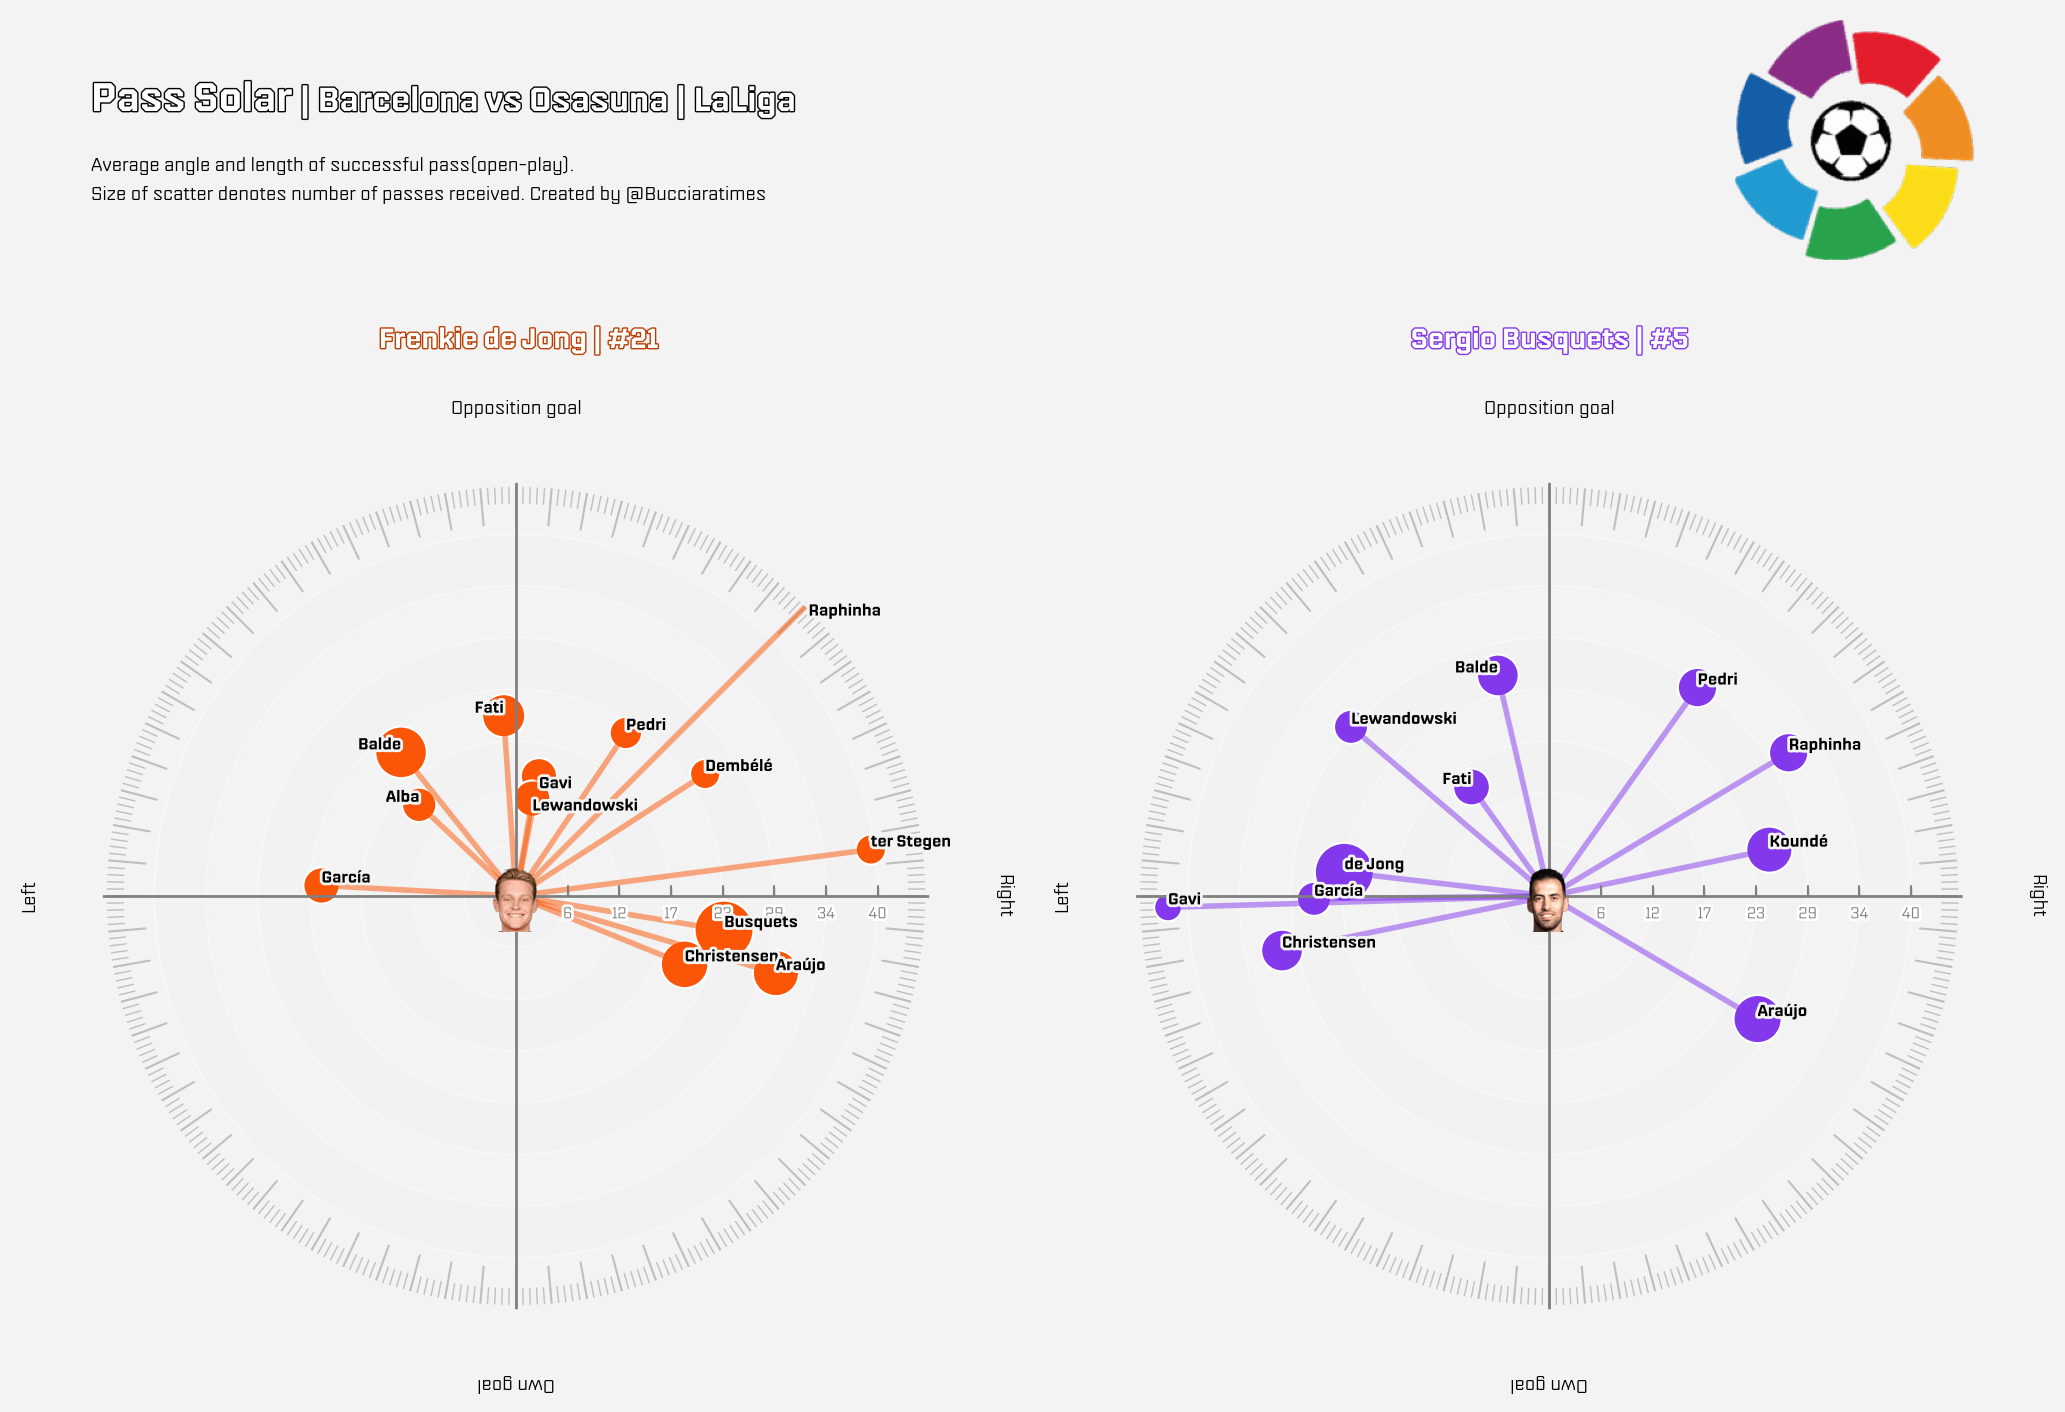

In [37]:
fig = plt.figure(dpi=200)
ax_one = plt.subplot(1, 2, 1, projection="polar", frameon=True)
ax_two = plt.subplot(1, 2, 2, projection="polar", frameon=True)

# -- one
one_color = "#fb5607"

plot_fancy_polar(ax_one)
sns.scatterplot(
    data=df_summary, x='angle', y='length_pass', color=one_color,
    size='num_passes', sizes=(100,450), legend=False, ax=ax_one, zorder=2)
ax_one.set_ylabel(None)
texts = []
df_annotate = df_summary[df_summary['annotate']]
for index in range(df_annotate.shape[0]):
    player_name = df_annotate['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_one.text(
            x=df_annotate['angle'].iloc[index], y=df_annotate['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Nippo', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(df_summary['length_pass']):
    ax_one.plot(
        [0, df_summary['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color=one_color
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_one)

# -- two
two_color = "#8338ec"

plot_fancy_polar(ax_two)
sns.scatterplot(
    data=df_summary2, x='angle', y='length_pass', color=two_color,
    size='num_passes', sizes=(100,450), legend=False, ax=ax_two, zorder=2)
ax_two.set_ylabel(None)
texts = []
df_annotate = df_summary2[df_summary2['annotate']]
for index in range(df_annotate.shape[0]):
    player_name = df_annotate['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_two.text(
            x=df_annotate['angle'].iloc[index], y=df_annotate['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Nippo', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(df_summary2['length_pass']):
    ax_two.plot(
        [0, df_summary2['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color=two_color
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_two)

plt.subplots_adjust(wspace=.25, hspace=-.5)

# =============================================================================== #

def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]

custom_path_effect_one = path_effect_stroke(linewidth=1, foreground='#bb3e03')
custom_path_effect_two = path_effect_stroke(linewidth=1, foreground='#8338ec')
custom_path_effect_title = path_effect_stroke(linewidth=1, foreground='#000000')



fig_text(
    x=0.12, y=1, s=f'<Pass Solar> | Barcelona vs {df.loc[0, "opponent"]} | LaLiga', family='Nippo',
    ha='left', va='center', weight='bold', size='large', color="#fefefe",
    highlight_textprops = [{'weight':'bold', 'size':'x-large'}],
    path_effects=custom_path_effect_title
)
fig_text(
    x=0.12, y=0.95, s='Average angle and length of successful pass(open-play).\nSize of scatter denotes number of passes received. Created by @Bucciaratimes', 
    family='Nippo',
    ha='left', va='center', size='x-small',
)

fig_text(
    x=0.24, y=.85, s=f'<{target_player_name}> | #21', family='Nippo',
    ha='left', va='center', weight='bold', size='medium', color="#fefefe",
    highlight_textprops = [{'weight':'bold', 'size':'medium'}],
    path_effects=custom_path_effect_one
)

fig_text(
    x=0.67, y=.85, s=f'<{target_player_name2}> | #5', family='Nippo',
    ha='left', va='center', weight='bold', size='medium', color="#fefefe",
    highlight_textprops = [{'weight':'bold', 'size':'medium'}],
    path_effects=custom_path_effect_two
)

image_ax = fig.add_axes(
    [.78, 0.9, .15, .15],
    fc='None'
)
fotmob_club_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/dark/87.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_club_url}')).convert('RGBA')
image_ax.imshow(club_icon)
image_ax.axis('off')

player_ax = fig.add_axes(
    [.277, .48, .04, .04],
    fc="None"
)
fotmob_player_url = "https://images.fotmob.com/image_resources/playerimages/638622.png"
player_icon = Image.open(urllib.request.urlopen(f'{fotmob_player_url}')).convert('RGBA')
player_ax.imshow(player_icon)
player_ax.axis('off')

player_ax2 = fig.add_axes(
    [.707, .48, .04, .04],
    fc="None"
)
fotmob_player_url2 = "https://images.fotmob.com/image_resources/playerimages/154257.png"
player_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_player_url2}')).convert('RGBA')
player_ax2.imshow(player_icon2)
player_ax2.axis('off')

plt.savefig(
	"/work/output/02012023_pass_solar.png",
	dpi = 200,
	facecolor = "#e3f2fd",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

plt.savefig(
	"/work/output/020120234_pass_solar_tr.png",
	dpi = 200,
	# facecolor = "none",
    facecolor="#fefefe",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)